In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [84]:
import torch
import torch.nn as nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import shutil
import sys

from torchinfo import summary
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from tqdm import tqdm
from collections import Counter
from PIL import Image
from pathlib import Path
import plotly.express as px
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# sys.path.append('/kaggle/input/helper_functions/pytorch/default/1')


import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import plot_random_images, predict, train, score, unnormalize_image, run_prediction

**IMPROVED: Enhanced data augmentation for better generalization**

**Validation transforms MUST include normalization to match training**

In [ ]:
# data_dir = Path('/kaggle/input/cassava-dataset')
full_data_dir = Path('datasets/train/train') #Path('/kaggle/input/full-cassava-dataset/train/train')
under_data_dir = Path('datasets/undersampled')
# train_dir= Path('/kaggle/input/cassava-dataset/kaggle_dataset/undersampled')
val_dir = Path('/kaggle/input/cassava-dataset/kaggle_dataset/test')
# train_dir.exists(), val_dir.exists(), data_dir.exists()

class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

train_transforms = T.Compose([
    ConvertToRGB(),
    T.Resize((320, 320)),
    T.RandomResizedCrop(300, scale=(0.7, 1.0)),  # More aggressive cropping
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.3),
    T.RandomRotation(degrees=30),  # Increased rotation
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    ConvertToRGB(),
    T.Resize((320, 320)),
    T.CenterCrop(300),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Use separate datasets with appropriate transforms
full_dataset_train = ImageFolder(full_data_dir, transform=train_transforms)
full_dataset_val = ImageFolder(full_data_dir, transform=val_transforms)
under_dataset_train = ImageFolder(under_data_dir, transform=train_transforms)
under_dataset_val = ImageFolder(under_data_dir, transform=val_transforms)

# Split indices instead of datasets to apply different transforms
from torch.utils.data import Subset
train_size = int(0.8 * len(full_dataset_train))
val_size = len(full_dataset_train) - train_size
indices = list(range(len(full_dataset_train)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]

full_train_dataset = Subset(full_dataset_train, train_indices)
full_test_dataset = Subset(full_dataset_val, val_indices)

under_train_size = int(0.8 * len(under_dataset_train))
under_indices = list(range(len(under_dataset_train)))
np.random.shuffle(under_indices)
under_train_indices, under_val_indices = under_indices[:under_train_size], under_indices[under_train_size:]

under_train_dataset = Subset(under_dataset_train, under_train_indices)
under_test_dataset = Subset(under_dataset_val, under_val_indices)


full_train_dataloader = DataLoader(full_train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
full_test_dataloader = DataLoader(full_test_dataset, shuffle=False, batch_size=32, num_workers=2, pin_memory=True)
under_train_dataloader = DataLoader(under_train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
under_test_dataloader = DataLoader(under_test_dataset, shuffle=False, batch_size=32, num_workers=2, pin_memory=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

class_names = full_dataset_train.classes
class_indexes = full_dataset_train.class_to_idx
num_classes = len(class_names)
print(class_names)
print(f"Training samples: {len(full_train_dataset)}, Validation samples: {len(full_test_dataset)}")

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [14]:
# [len(os.listdir(os.path.join(train_dir, i))) for i in classes]
class_dir_dict = {}
for i in class_names:
    class_dir_dict[i] = len(list((full_data_dir/i).iterdir()))
class_dir_dict = pd.Series(class_dir_dict).rename('class')
fig = px.bar(class_dir_dict, x=class_dir_dict.values, y=class_dir_dict.index)
fig.update_layout(xaxis_title='Count', yaxis_title='Disease', title='Dataset Distribution')
fig.show()

**Incorporating mixed precision training and early stopping**

In [ ]:
from torch.cuda.amp import autocast, GradScaler

# Use mixed precision training for faster performance
scaler = GradScaler() if device == 'cuda' else None

# Use early stopping to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

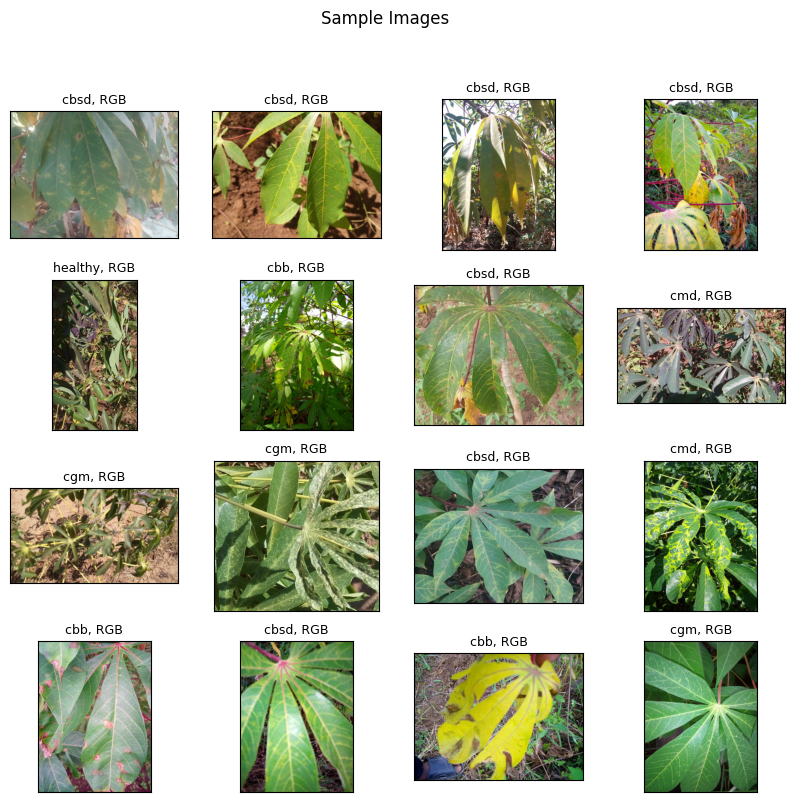

In [15]:
plot_random_images(full_data_dir, classes=class_names, nrows=4, ncols=4)

**In this below cell, I want to try out the following steps to see if potentil imporvements will happen, they are about improving the model architecture and training setup**

In [ ]:
# Better model architecture and training setup
model = models.efficientnet_b3(weights="IMAGENET1K_V1")

# More sophisticated classifier head
final_layer = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, num_classes)
)

# unfreeze the model for better training
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 3 blocks of EfficientNet for fine-tuning
for param in model.features[-3:].parameters():
    param.requires_grad = True

model.classifier = final_layer
model = model.to(device)

# Different learning rates for pretrained vs new layers
optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Lower LR for pretrained
    {'params': model.classifier.parameters(), 'lr': 1e-3}  # Higher LR for new layers
], weight_decay=0.01)

# Add learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Handle class imbalance with weighted loss
# Calculate class weights based on dataset distribution
class_counts = [len(list((full_data_dir/cls).iterdir())) for cls in class_names]
class_weights = torch.tensor([1.0 / count for count in class_counts], device=device)
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

print(f"Model on device: {next(model.parameters()).device}")
print(f"Class weights: {class_weights}")

NameError: name 'models' is not defined

**IMPROVED Training with all enhancements**

**I also think u should consider increasing epochs since we have early stopping now, as early stopping will handle overfitting now**

In [ ]:
full_dataset_results = train(
    model,
    optimizer,
    loss_fn,
    under_train_dataloader,
    under_test_dataloader,
    epochs=30
    device=device
)

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.95
    Training accuracy: 0.66
    Validation loss: 0.97
    Validation accuracy: 0.65


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.79
    Training accuracy: 0.72
    Validation loss: 0.82
    Validation accuracy: 0.70


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.73
    Training accuracy: 0.75
    Validation loss: 0.75
    Validation accuracy: 0.74


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.66
    Training accuracy: 0.78
    Validation loss: 0.69
    Validation accuracy: 0.76


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.62
    Training accuracy: 0.79
    Validation loss: 0.65
    Validation accuracy: 0.78


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.60
    Training accuracy: 0.79
    Validation loss: 0.64
    Validation accuracy: 0.77


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.58
    Training accuracy: 0.80
    Validation loss: 0.62
    Validation accuracy: 0.79


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.57
    Training accuracy: 0.81
    Validation loss: 0.61
    Validation accuracy: 0.80


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.55
    Training accuracy: 0.81
    Validation loss: 0.60
    Validation accuracy: 0.81


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.55
    Training accuracy: 0.81
    Validation loss: 0.61
    Validation accuracy: 0.79


In [247]:
torch.save(model.state_dict(), 'cassava_disease_model1.pth')

In [163]:
model_results_df = torch.load('cassava_model_results.pth', map_location=device)
fig = px.line(model_results_df[['Training accuracy', 'Validation accuracy']])
fig.update_layout(xaxis_title='Epochs', yaxis_title='Accuracy', title='Model Accuracies')
fig.show()

In [162]:
fig = px.line(model_results_df[['Training loss', 'Validation loss']])
fig.update_layout( xaxis_title='Epochs', yaxis_title='Loss', title='Model Loss')
fig.show()

In [ ]:
def make_predictions(model, dataset, number_of_images=30):
    correct = 0
    random_idx = random.sample(range(len(dataset)), number_of_images)
    preds, actual_labels, all_images = [], [], []
    for idx in random_idx:
        random_img, random_label = dataset[idx]
        all_images.append(random_img)
        random_img = random_img.to(device)
        with torch.no_grad():
            output = model(random_img.unsqueeze(0))
            pred = output.argmax().item()
            predicted_label = class_names[pred]
            actual_label = class_names[random_label]
            preds.append(predicted_label)
            actual_labels.append(actual_label)
            if predicted_label == actual_label:
                correct+=1
            # print(predicted_label,actual_label)
    print(correct/number_of_images)


    all_images_normalized = [unnormalize_image(img).permute(2,0,1) for img in all_images]

    fig, ax = plt.subplots(figsize=(10,13), nrows=math.ceil(number_of_images/5), ncols=5)
    fig.tight_layout()
    ax = ax.flatten()
    for i, axis in enumerate(ax):
        # axis.set_xlim(100, 1000)
        axis.imshow(to_pil_image(all_images_normalized[i]))
        color = 'green' if preds[i] == actual_labels[i] else 'red'
        axis.set_title(f'Actual: {actual_labels[i]}\n Pred:{preds[i]}', fontsize=12, color=color)
        axis.axis('off')

0.8333333333333334


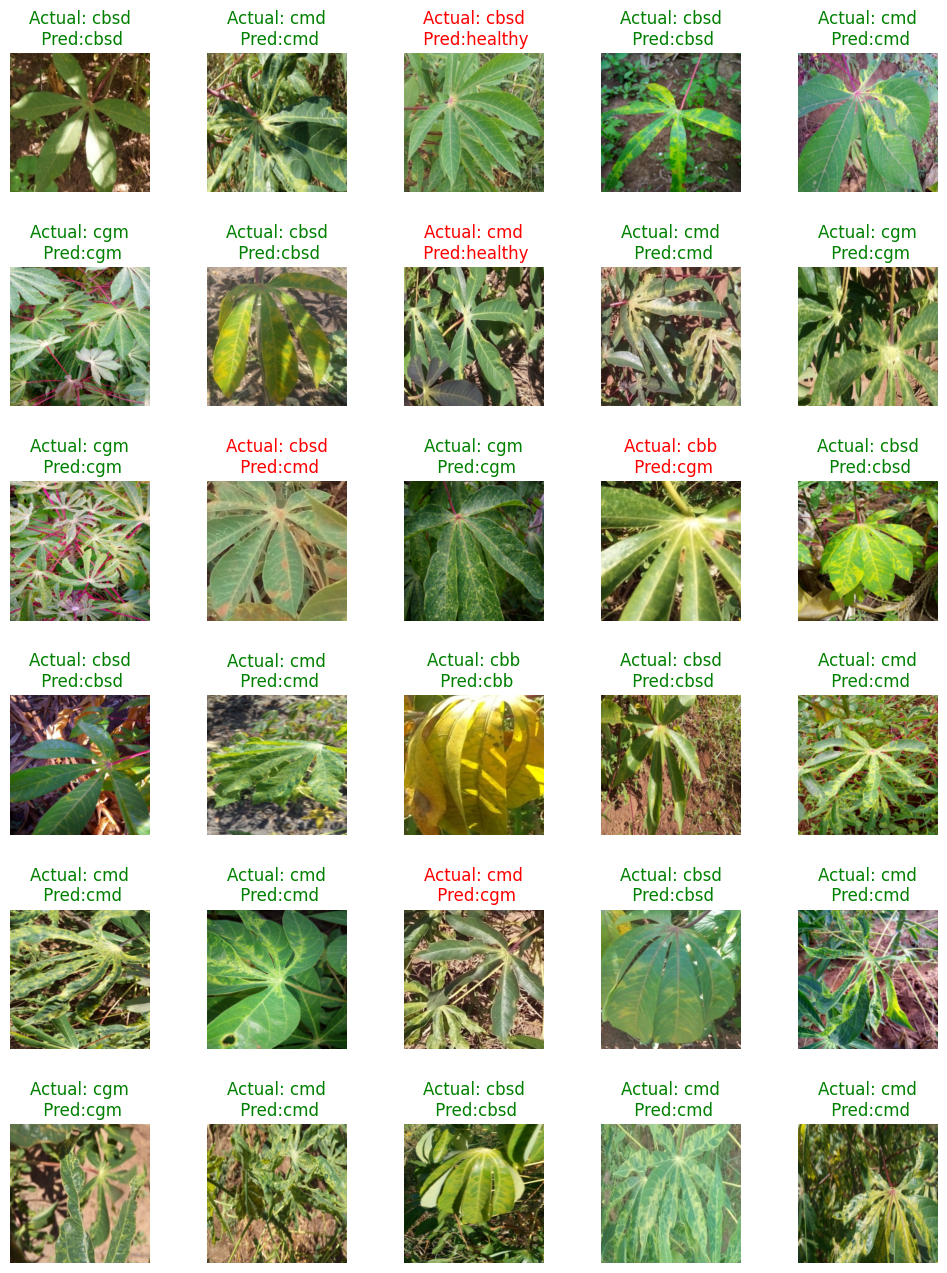

In [16]:
make_predictions(trained_model, full_test_dataset, 30)

In [7]:
trained_model = torch.load('best_cassava_model.pth', map_location=device)

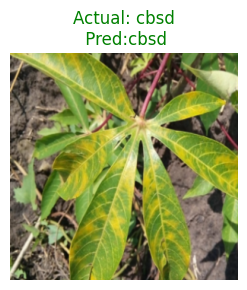

In [ ]:
def make_prediction(model, dataset):
    correct = 0
    random_idx = random.choice(range(len(dataset)))
    # preds, actual_labels, all_images = [], [], []
    random_img, random_label = dataset[random_idx]
    random_img = random_img.to(device)
    with torch.no_grad():
        output = model(random_img.unsqueeze(0))
        pred = output.argmax().item()
        predicted_label = class_names[pred]
        actual_label = class_names[random_label]


    unnormalized_img = unnormalize_image(random_img)

    fig, ax = plt.subplots(figsize=(3,3))
    fig.tight_layout()
    ax.imshow(unnormalized_img)
    color = 'green' if predicted_label == actual_label else 'red'
    ax.set_title(f'Actual: {actual_label}\n Pred:{predicted_label}', fontsize=12, color=color)
    ax.axis('off')

make_prediction(trained_model, full_test_dataset)

'cbb'

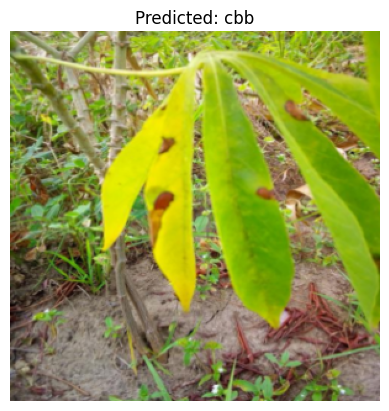

In [86]:
run_prediction('datasets/train/train/cbb/train-cbb-106.jpg', trained_model)

## Unknown/Out-of-Distribution Image Detection

The following techniques help detect when an image doesn't belong to any of the trained classes:
1. **Confidence Thresholding** - Reject predictions with low confidence
2. **Entropy-based Detection** - High entropy indicates uncertainty
3. **Maximum Softmax Probability** - Low max probability suggests OOD
4. **Temperature Scaling** - Calibrate confidence scores


### Method 1: Confidence Thresholding

In [ ]:
def predict_with_confidence_threshold(model, image_path, confidence_threshold=0.7):
    """
    Predict with confidence threshold to detect unknown images.
    Returns 'Unknown' if confidence is below threshold.
    """
    model.eval()

    # Load and preprocess image
    img = Image.open(image_path)
    img_tensor = val_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = probabilities.max(dim=1)

    confidence_value = confidence.item()

    if confidence_value < confidence_threshold:
        return "Unknown", confidence_value, probabilities[0].cpu().numpy()
    else:
        return class_names[predicted_class.item()], confidence_value, probabilities[0].cpu().numpy()


prediction, confidence, probs = predict_with_confidence_threshold(
    trained_model,
    'model/image.jpg',
    confidence_threshold=0.7
)
print(f"Prediction: {prediction}, Confidence: {confidence:.2%}")

### Method 2: Entropy-based Detection

In [ ]:
def predict_with_entropy_threshold(model, image_path, entropy_threshold=1.5):
    """
    Use entropy to detect unknown images.
    High entropy = high uncertainty = likely unknown.
    Entropy ranges from 0 (certain) to log(num_classes) (maximum uncertainty).
    """
    model.eval()

    img = Image.open(image_path)
    img_tensor = val_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)

        # Calculate entropy: -sum(p * log(p))
        entropy = -(probabilities * torch.log(probabilities + 1e-10)).sum(dim=1)

        confidence, predicted_class = probabilities.max(dim=1)

    entropy_value = entropy.item()
    max_entropy = np.log(num_classes)  # Maximum possible entropy

    if entropy_value > entropy_threshold:
        return "Unknown", confidence.item(), entropy_value, max_entropy
    else:
        return class_names[predicted_class.item()], confidence.item(), entropy_value, max_entropy


prediction, confidence, entropy, max_entropy = predict_with_entropy_threshold(
    trained_model,
    'model/image.jpg',
    entropy_threshold=1.5
)
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.2%}")
print(f"Entropy: {entropy:.3f} / {max_entropy:.3f}")

### Method 3: Combined Multi-Criteria Detection

In [ ]:
def predict_with_unknown_detection(model, image_path,
                                   confidence_threshold=0.65,
                                   entropy_threshold=1.5,
                                   use_tta=False,
                                   visualize=True):
    """
    Comprehensive unknown detection using multiple criteria:
    - Confidence threshold
    - Entropy threshold
    - Test-Time Augmentation (optional)

    Returns detailed prediction with uncertainty metrics.
    """
    model.eval()

    img = Image.open(image_path)

    if use_tta:
        # Use Test-Time Augmentation for more robust predictions
        num_augmentations = 5
        all_probs = []

        tta_transforms_list = T.Compose([
            ConvertToRGB(),
            T.Resize((320, 320)),
            T.RandomResizedCrop(300, scale=(0.9, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        with torch.no_grad():
            for _ in range(num_augmentations):
                img_tensor = tta_transforms_list(img).unsqueeze(0).to(device)
                output = model(img_tensor)
                probs = F.softmax(output, dim=1)
                all_probs.append(probs)

        probabilities = torch.stack(all_probs).mean(dim=0)
    else:
        img_tensor = val_transforms(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = F.softmax(output, dim=1)

    # Calculate metrics
    confidence, predicted_class = probabilities.max(dim=1)
    entropy = -(probabilities * torch.log(probabilities + 1e-10)).sum(dim=1)

    confidence_value = confidence.item()
    entropy_value = entropy.item()
    predicted_idx = predicted_class.item()

    # Decision logic
    is_unknown = (confidence_value < confidence_threshold) or (entropy_value > entropy_threshold)

    result = {
        'prediction': "Unknown" if is_unknown else class_names[predicted_idx],
        'confidence': confidence_value,
        'entropy': entropy_value,
        'max_entropy': np.log(num_classes),
        'is_unknown': is_unknown,
        'top_3_predictions': [],
        'all_probabilities': probabilities[0].cpu().numpy()
    }

    # Get top 3 predictions
    top3_probs, top3_indices = probabilities[0].topk(min(3, num_classes))
    for prob, idx in zip(top3_probs, top3_indices):
        result['top_3_predictions'].append({
            'class': class_names[idx.item()],
            'probability': prob.item()
        })

    if visualize:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.imshow(img)
        color = 'orange' if is_unknown else 'green'
        title = f"Prediction: {result['prediction']}\n"
        title += f"Confidence: {confidence_value:.2%}\n"
        title += f"Entropy: {entropy_value:.3f}/{np.log(num_classes):.3f}"
        ax1.set_title(title, fontsize=12, color=color, weight='bold')
        ax1.axis('off')

        # Show probability distribution
        probs_np = probabilities[0].cpu().numpy()
        bars = ax2.barh(class_names, probs_np)

        for i, bar in enumerate(bars):
            if i == predicted_idx and not is_unknown:
                bar.set_color('green')
            else:
                bar.set_color('lightgray')

        ax2.set_xlabel('Probability')
        ax2.set_title('Class Probabilities')
        ax2.set_xlim(0, 1)

        ax2.axvline(x=confidence_threshold, color='red', linestyle='--',
                   label=f'Threshold ({confidence_threshold})')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    return result

result = predict_with_unknown_detection(
    trained_model,
    'model/image.jpg',
    confidence_threshold=0.65,
    entropy_threshold=1.5,
    use_tta=True,
    visualize=True
)
print(f"\nPrediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Is Unknown: {result['is_unknown']}")
print("\nTop 3 Predictions:")
for i, pred in enumerate(result['top_3_predictions'], 1):
    print(f"  {i}. {pred['class']}: {pred['probability']:.2%}")

### Determine optimal thresholds using validation set

In [ ]:
def calibrate_thresholds(model, dataset, percentile=95):
    """
    Analyze the validation dataset to determine optimal thresholds.
    Use this to set appropriate confidence and entropy thresholds.

    Args:
        model: Trained model
        dataset: Validation dataset (should contain only known classes)
        percentile: Percentile to use for threshold (e.g., 95 means 95% of known images pass)

    Returns:
        Dictionary with recommended thresholds
    """
    model.eval()

    confidences = []
    entropies = []
    correct_predictions = 0
    total = 0

    print(f"Analyzing {len(dataset)} validation samples...")

    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

            # Get confidence (max probability)
            conf, preds = probabilities.max(dim=1)
            confidences.extend(conf.cpu().numpy())

            # Calculate entropy
            entropy = -(probabilities * torch.log(probabilities + 1e-10)).sum(dim=1)
            entropies.extend(entropy.cpu().numpy())

            # Track accuracy
            correct_predictions += (preds == labels.to(device)).sum().item()
            total += labels.size(0)

    confidences = np.array(confidences)
    entropies = np.array(entropies)

    # Calculate thresholds
    # Use low percentiles for confidence (e.g., 5th percentile = threshold below which 5% of known images fall)
    confidence_threshold = np.percentile(confidences, 100 - percentile)

    # Use high percentiles for entropy (e.g., 95th percentile = threshold above which 5% of known images fall)
    entropy_threshold = np.percentile(entropies, percentile)

    results = {
        'confidence_threshold': confidence_threshold,
        'entropy_threshold': entropy_threshold,
        'validation_accuracy': correct_predictions / total,
        'mean_confidence': confidences.mean(),
        'std_confidence': confidences.std(),
        'mean_entropy': entropies.mean(),
        'std_entropy': entropies.std(),
        'max_entropy': np.log(num_classes)
    }

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confidence distribution
    axes[0].hist(confidences, bins=50, alpha=0.7, edgecolor='black')
    axes[0].axvline(confidence_threshold, color='red', linestyle='--',
                    label=f'Threshold: {confidence_threshold:.3f}')
    axes[0].set_xlabel('Confidence (Max Probability)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Confidence Distribution on Validation Set')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Entropy distribution
    axes[1].hist(entropies, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1].axvline(entropy_threshold, color='red', linestyle='--',
                    label=f'Threshold: {entropy_threshold:.3f}')
    axes[1].axvline(np.log(num_classes), color='blue', linestyle=':',
                    label=f'Max Entropy: {np.log(num_classes):.3f}')
    axes[1].set_xlabel('Entropy')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Entropy Distribution on Validation Set')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("CALIBRATION RESULTS")
    print("="*60)
    print(f"Validation Accuracy: {results['validation_accuracy']:.2%}")
    print(f"\nRecommended Thresholds (for {percentile}% coverage):")
    print(f"  Confidence Threshold: {confidence_threshold:.4f}")
    print(f"  Entropy Threshold: {entropy_threshold:.4f}")
    print(f"\nConfidence Statistics:")
    print(f"  Mean: {results['mean_confidence']:.4f}")
    print(f"  Std Dev: {results['std_confidence']:.4f}")
    print(f"\nEntropy Statistics:")
    print(f"  Mean: {results['mean_entropy']:.4f}")
    print(f"  Std Dev: {results['std_entropy']:.4f}")
    print(f"  Max Possible: {results['max_entropy']:.4f}")
    print("="*60)

    return results

thresholds = calibrate_thresholds(trained_model, full_test_dataset, percentile=95)

# Then use the calibrated thresholds:
result = predict_with_unknown_detection(
    trained_model,
    'model/image.jpg',
    confidence_threshold=thresholds['confidence_threshold'],
    entropy_threshold=thresholds['entropy_threshold'],
    use_tta=True,
    visualize=True
)

## Testing

### Process multiple images with unknown detection

In [ ]:
def batch_predict_with_unknown_detection(model, image_paths,
                                         confidence_threshold=0.65,
                                         entropy_threshold=1.5):
    """
    Process multiple images and return predictions with unknown detection.
    Useful for production deployment.
    """
    model.eval()
    results = []

    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            img = Image.open(img_path)
            img_tensor = val_transforms(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                probabilities = F.softmax(output, dim=1)

                confidence, predicted_class = probabilities.max(dim=1)
                entropy = -(probabilities * torch.log(probabilities + 1e-10)).sum(dim=1)

                confidence_value = confidence.item()
                entropy_value = entropy.item()

                is_unknown = (confidence_value < confidence_threshold) or (entropy_value > entropy_threshold)

                results.append({
                    'image_path': img_path,
                    'prediction': "Unknown" if is_unknown else class_names[predicted_class.item()],
                    'confidence': confidence_value,
                    'entropy': entropy_value,
                    'is_unknown': is_unknown
                })
        except Exception as e:
            results.append({
                'image_path': img_path,
                'prediction': 'Error',
                'confidence': 0.0,
                'entropy': 0.0,
                'is_unknown': True,
                'error': str(e)
            })

    return pd.DataFrame(results)


image_list = ['image1.jpg', 'image2.jpg', 'unknown_image.jpg']
results_df = batch_predict_with_unknown_detection(
    trained_model,
    image_list,
    confidence_threshold=0.65,
    entropy_threshold=1.5
)
print(results_df)
print(f"\nUnknown images detected: {results_df['is_unknown'].sum()}")